### Simulation setup
TRAPPIST-1 planet data from Huang & Ormel (2022):
<center>
<img width=500 src="./Figures/trappist1_data.png"></img>
</center>

In [338]:
import rebound
import reboundx
import numpy as np
import matplotlib.pyplot as plt

# Create the simulation
sim = rebound.Simulation()
sim.units = ('AU', 'yr', 'Msun')
sim.integrator = "whfast"

# Add the star
sim.add(m=0.09)

# Define planet masses (converted to Msun), semi‐major axes (AU), and eccentricities
masses = np.array([1.374, 1.308, 0.388, 0.692, 1.039, 1.321, 0.326]) * 3.003e-6

# Default a values
# a0 = np.array([1.154, 1.580, 2.227, 2.925, 3.849, 4.683, 6.189]) * 0.01  

# Figure 3 imitation
b_a = 1.3
a0 = np.array([b_a, b_a*2**(2/3)*1.01, b_a*2**(4/3)*1.03, b_a*2**(4/3)*1.5**(2/3)*1.07, b_a*2**(4/3)*1.5**(4/3)*1.1, b_a*2**(4/3)*1.5**(6/3)*1.13, b_a*2**(4/3)*1.5**(8/3)*1.15]) * 0.01  
e0 = np.array([0.004, 0.002, 0.006, 0.0065, 0.009, 0.004, 0.0035])
num_planets = len(masses)

### Disk Parameters
From Huang & Ormel (2022):
<center>
<img width=400 src="./Figures/Huang_parameters.png"></img>
</center>

Depending on the model, the parameters are changed.
- In the `bC` model, $\tau_{a,\oplus}=5e3$, $C_e =0.1$, and $r_c=0.013$ (observed location of planet b).
- In the `dCcgI` model, $r_c = 0.023$ (observed location of planet d).

In [339]:
# Free parameters
tau_a_earth = 10e3
C_e = 0.1 
r_c = 0.013
A_a = 50
A_e = 1

# Other parameters
h = 0.03
M_g_dot = 10e-10
M_star = 0.09
gamma_I = 2
tau_d = 1e5
Delta = 2*h*r_c
Q_sim = 100

### Reboundx forces
We add the following forces using `REBOUNDx`:
- `type_I_migration`
- `modify_orbits_forces`
- `tides_constant_time_lag`

In [340]:
rebx = reboundx.Extras(sim)

# type I migration
# mig = rebx.load_force("type_I_migration")
# rebx.add_force(mig)

# Orbital damping
mof = rebx.load_force("modify_orbits_forces")
rebx.add_force(mof)

# Tidal damping
# tides = rebx.load_force("tides_constant_time_lag")
# rebx.add_force(tides)

### Type I Migration
* The disk scale height in code units (here AU), 1 code unit from the central star ($h_1$) 
* The disk surface density 1 code unit from the central star ($\Sigma_1$) 
* The disk surface density exponent ($\alpha$), assuming a power law $\Sigma(r) = \Sigma_1 r^{-\alpha}$, where $r$ is the radial distance from the star in code units
* The disk flaring index ($\beta$), assuming a power-law scale height $h(r) = h_1 r^\beta$

In [341]:
# mig.params["tIm_scale_height_1"] = 0.03
# mig.params["tIm_surface_density_1"] = 1.1e-4 # 1000 g/cm^2 surface density in Msun/AU^2
# mig.params["tIm_surface_density_exponent"] = 1
# mig.params["tIm_flaring_index"] = 0.25

### Adding an inner disk edge (ide) to halt migration
An artificial prescription for halting the planet at `ide_position` (in AU). 

We also have to set the 'width' of the ide. This is the width of the region in which the migration torque flips sign, so the planet will stop within this distance scale of the inner disk edge's location. 

Here we set the width to the scale height of the disk at the inner disk edge:

In [342]:
# mig.params["ide_position"] = 0.02
# mig.params["ide_width"] = mig.params["tIm_scale_height_1"]*mig.params["ide_position"]**mig.params["tIm_flaring_index"]
# print('Planet will stop within {0:.3f} AU of the inner disk edge at {1} AU'.format(mig.params["ide_width"], mig.params["ide_position"]))

### Orbital Damping
We calculate the semi-major axis damping timescale and eccentricity damping timescale based on these equations from Huang & Ormel (2022):
<center>
<img width=400 src="./Figures/Huang_timescales.png"></img>
</center>

Though not computed here, note that $\Omega_K = \sqrt{\dfrac{GM_{\star}}{r^3}}$ is the Keplerian angular velocity.

In [343]:
q_vals = masses / M_star
q_earth =  3.003e-6 / M_star

def f_functions(r):
    # Piecewise functions f_a and f_e
    conditions = [
        r < r_c - Delta,
        (r_c - Delta <= r) & (r < r_c),
        (r_c <= r) & (r < r_c + Delta + 1 / A_a),
        r >= r_c + Delta + 1 / A_a
    ]

    f_a = [
        0,          
        A_a * (r_c - Delta - r) / Delta,
        (r-r_c)* (A_a + 1) / (Delta + 1/A_a) - (A_a), # modified to make it continuous, paper might be wrong
        1
    ]

    f_e = [
        0,          
        A_e * (r - r_c + Delta) / Delta,
        (A_e - 1) * (r_c + Delta + 1 / A_a - r) / (Delta + 1 / A_a) + 1, 
        1
    ]

    f_a_vals = np.select(conditions, f_a, default=np.nan)
    f_e_vals = np.select(conditions, f_e, default=np.nan)
    return f_a_vals, f_e_vals

# %matplotlib inline
# # Temporary
# A_e = 2
# A_a = 3
# r_c = 9
# Delta = 3

# # %matplotlib widget

# fig, ax = plt.subplots()
# fig.set_figwidth(4.0)
# fig.set_figheight(4.0)

# xs = np.linspace(0, 3*r_c, 100)
# f_a_vals, f_e_vals = f_functions(xs)
# ax.plot(xs, f_a_vals, label='f_a')  
# ax.plot(xs, f_e_vals, label='f_e')  
# plt.ylabel("$f_a$ or $f_e$")
# plt.xlabel("Distance from the star")
# plt.legend()
# plt.show()


### Tidal Damping
To be implemented.

We set the timestep to 5% of the orbital period of Planet b to make sure we always resolve the orbit

In [344]:
sim.integrator = 'whfast'
# sim.dt = ps[1].a**(3/2)/20
# print(sim.dt)
sim.dt = 0.001 # so it runs faster

### Integrate and Record

In [345]:
time_steps = 5000
times = np.linspace(0, 10000, time_steps)

a_vals, e_vals, n_vals, P_vals = np.full((num_planets, time_steps), np.nan), np.full((num_planets, time_steps), np.nan), np.full((num_planets, time_steps), np.nan), np.full((num_planets, time_steps), np.nan)
P_ratios = np.full((num_planets-1, time_steps), np.nan)

# Add planets 
for i in range(2): # b and c only
    sim.add(m=masses[i], a=a0[i], e=e0[i])

# Move to center of momentum
sim.move_to_com()
ps = sim.particles

injection_schedule = {
    300: 2,
    600: 3,
    900: 4,
    1200: 5,
    1500: 6
}

for i, t in enumerate(times):
    sim.integrate(t)
    
    if i in injection_schedule:
        idx = injection_schedule[i]
        sim.add(m=masses[idx], a=a0[idx], e=e0[idx])
        sim.move_to_com()
        ps = sim.particles
        
    for j, p in enumerate(ps[1:]):  # skip the star
        a_vals[j, i] = p.a
        e_vals[j, i] = p.e
        n_vals[j, i] = np.sqrt(sim.G * ps[0].m / p.a**3) 
        P_vals[j, i] = 2 * np.pi / n_vals[j, i]
    for j, p in enumerate(ps[1:7]):  # first 6 planet pairs
        P_ratios[j, i] = P_vals[j+1, i] / P_vals[j, i]
        
    f_a_vals, f_e_vals = f_functions(a_vals[:, i])
    for j, p in enumerate(ps[1:]):
        if j == 6: # Planet h
            p.params["tau_a"] = -tau_a_earth * (q_earth / q_vals[j]) / f_a_vals[j] # negative so it is damping      
            print(f"h: {p.params['tau_a']}")    
        elif j == 5: # Planet g
            p.params["tau_a"] = -tau_a_earth * (q_earth / q_vals[j]) / f_a_vals[j]
            
            p.params["tau_a"] *= 2 # divide tau_a for g by 2 to prevent overaggressive plowing
            print(f"g: {p.params['tau_a']}")    
        else:
            p.params["tau_a"] = 1e32 # turns off migration
            
        if p.params["tau_a"] == -np.inf:
            p.params["tau_a"] = 1e32 # turns off migration
            
    if i == 1:
        pass
        # print(j, p.params["tau_a"])

    for j, p in enumerate(ps[1:]): # skip star at index 0
        # p.params["tau_e"] = -C_e * h**2 * p.params["tau_a"] * f_a_vals[j] / f_e_vals[j]
        p.params["tau_e"] = -100 
        
        # print(j, p.params["tau_e"])
    # if 2800 < i and i < 4000:
    #     print(i, [p.params["tau_a"] for p in ps[1:]])

g: -15140.04542013626
g: -15140.04542013626
g: -15140.04542013626
g: -15140.04542013626
g: -15140.04542013626
g: -15140.04542013626
g: -15140.04542013626
g: -15140.04542013626
g: -15140.04542013626
g: -15140.04542013626
g: -15140.04542013626
g: -15140.04542013626
g: -15140.04542013626
g: -15140.04542013626
g: -15140.04542013626
g: -15140.04542013626
g: -15140.04542013626
g: -15140.04542013626
g: -15140.04542013626
g: -15140.04542013626
g: -15140.04542013626
g: -15140.04542013626
g: -15140.04542013626
g: -15140.04542013626
g: -15140.04542013626
g: -15140.04542013626
g: -15140.04542013626
g: -15140.04542013626
g: -15140.04542013626
g: -15140.04542013626
g: -15140.04542013626
g: -15140.04542013626
g: -15140.04542013626
g: -15140.04542013626
g: -15140.04542013626
g: -15140.04542013626
g: -15140.04542013626
g: -15140.04542013626
g: -15140.04542013626
g: -15140.04542013626
g: -15140.04542013626
g: -15140.04542013626
g: -15140.04542013626
g: -15140.04542013626
g: -15140.04542013626
g: -15140.

### Plotting semi-major axis and eccentricity evolution

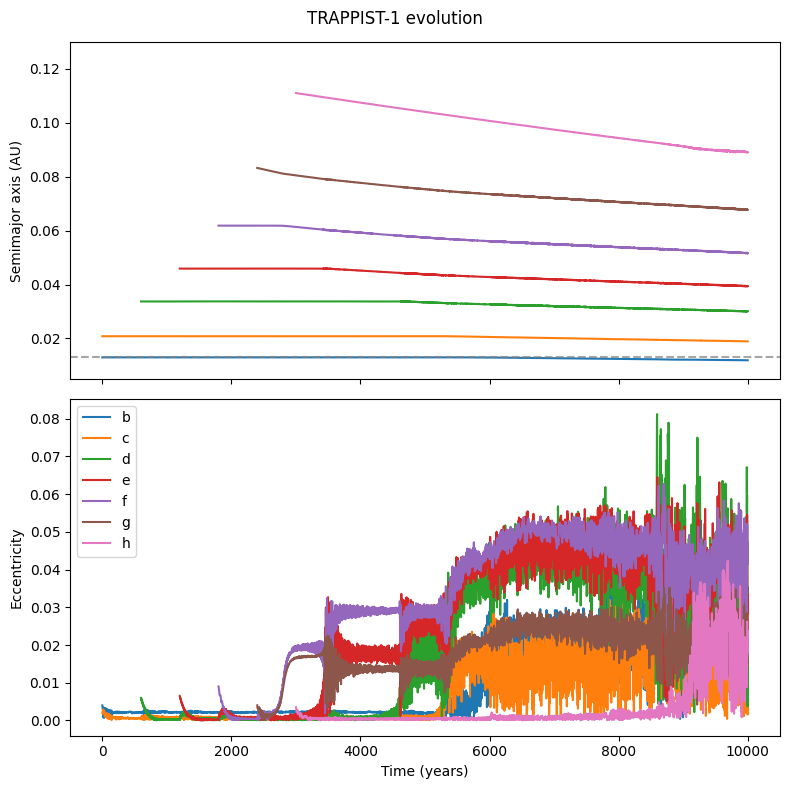

In [ ]:
%matplotlib inline

fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
fig.set_figwidth(8.0)
fig.set_figheight(8.0)

for j in range(len(masses)):
    # could also try plotting log
    ax1.plot(times, a_vals[j], label=f'{chr(98+j)}')  # b, c, d, ...
    ax2.plot(times, e_vals[j], label=f'{chr(98+j)}')  
plt.xlabel("Time (years)")
ax1.set_ylabel("Semimajor axis (AU)")
ax2.set_ylabel("Eccentricity")
ax1.set_ylim(0.005, 0.13)
# ax2.set_ylim(-0.01, 0.2)

# Plot truncation radius 
ax1.axhline(r_c, color='gray', ls='--', alpha=0.7)

fig.subplots_adjust(hspace=0)

plt.suptitle("TRAPPIST-1 evolution")
plt.legend()
plt.tight_layout()
plt.show()

### Resonance Ratios

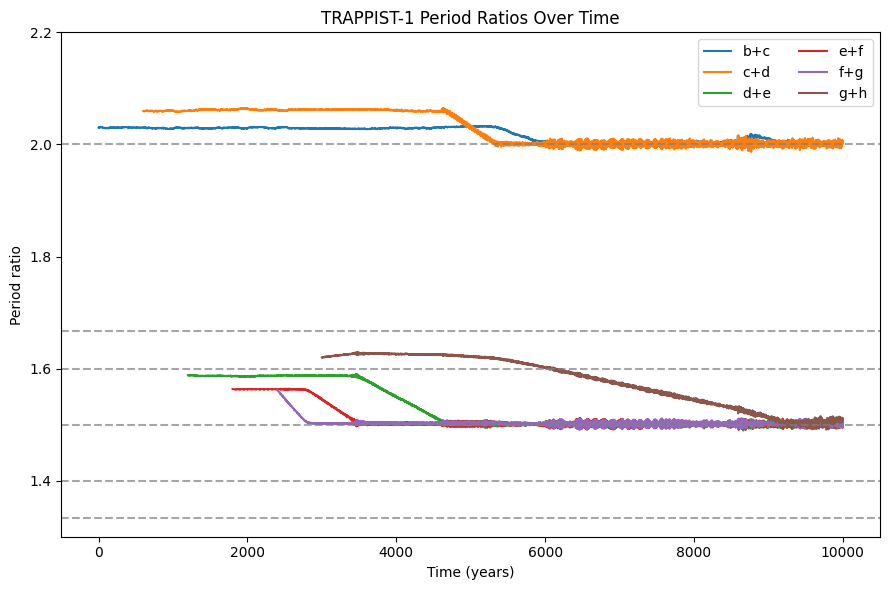

In [349]:
plt.figure(figsize=(9,6))
labels = [f"{chr(98+j-1)}+{chr(98+j)}" for j in range(1, 7)]  # b,c,d,...
for j in range(6):
    plt.plot(times, P_ratios[j], label=labels[j])

# Add horizontal lines for nearby resonances
resonances = [2, 8/5, 7/5, 5/3, 3/2, 4/3]
for r in resonances:
    plt.axhline(r, color='gray', ls='--', alpha=0.7)

plt.xlabel("Time (years)")
plt.ylabel("Period ratio")
plt.ylim(1.3, 2.2)
plt.title("TRAPPIST-1 Period Ratios Over Time")
plt.legend(ncol=2)
plt.tight_layout()
plt.show()


### Check for resonance
Using the formula $(p+q)\lambda_2 - p\lambda_1 - q \varpi_1$.

### Calculating Laplace coefficients

In [348]:
# from pylaplace import LaplaceCoefficient

# alpha = 0.9   # a1/a2
# l = LaplaceCoefficient(alpha)
# b_12_1 = l.b(1/2, 1)    # b_{1/2}^{(1)}(α)
# b_32_2 = l.b(3/2, 2)    # b_{3/2}^{(2)}(α)
# print(b_12_1, b_32_2)